In [1]:
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense,Conv2D,Flatten,BatchNormalization,Dropout,MaxPooling2D,Input
from keras.callbacks import ReduceLROnPlateau

2024-04-15 12:31:45.636691: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-15 12:31:45.636805: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-15 12:31:45.922613: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical


def preprocess(data_dir,size):
    df=pd.read_csv(data_dir)

    Label = df["label"]
    Data = df.drop(columns=["label"])

    print("Balancing the Data")

    oversample = RandomOverSampler()
    Data, Label  = oversample.fit_resample(Data, Label)
     
    print('Shape of Data :', Data.shape)

    print("Balancing the Data: Complete")
    Data = np.array(Data).reshape(-1, size[0], size[1] , 3)
    Label = np.array(Label)
    X_train , X_test , y_train , y_test = train_test_split(Data , Label , test_size = 0.25 , random_state = 49)

    X_train=X_train/255.0
    X_test=X_test/255.0
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)

    return X_train,X_test,y_train,y_test



In [3]:
def transfer_learning_model(base_model,X_train,X_test,y_train,y_test,
                            optimizer="Adam",loss="categorical_crossentropy",
                            metrics=['accuracy'],epochs=30,batch_size=128):
    
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy'
                                            , patience = 2
                                            , verbose=1
                                            ,factor=0.5
                                            , min_lr=0.00001)

    x = Flatten()(base_model.output)
    x = Dropout(0.2)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(32, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(16, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(7, activation='softmax')(x)


    model = Model(inputs=base_model.input, outputs=x)

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
#     model.summary()

    history=model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    callbacks=[learning_rate_reduction]
    )

    return model,history

In [4]:
data_dir='/kaggle/input/pixel-data-56-56/pixel_data_56_56.csv'
size=[56,56]

In [5]:
X_train_56_56,X_test_56_56,y_train_56_56,y_test_56_56=preprocess(data_dir=data_dir,size=size)

Balancing the Data
Shape of Data : (46935, 9408)
Balancing the Data: Complete


In [6]:
from keras.applications import VGG19

In [7]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(size[0], size[1], 3))
for layer in base_model.layers:
    layer.trainable = False
model_56_56_vgg,history_56_56_vgg=transfer_learning_model(base_model=base_model,X_train=X_train_56_56,X_test=X_test_56_56,y_train=y_train_56_56,y_test=y_test_56_56,epochs=30)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
  2/276 ━━━━━━━━━━━━━━━━━━━━ 20s 76ms/step - accuracy: 0.1309 - loss: 2.4675   

I0000 00:00:1713184453.519310      88 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


276/276 ━━━━━━━━━━━━━━━━━━━━ 51s 112ms/step - accuracy: 0.3604 - loss: 1.6771 - val_accuracy: 0.5687 - val_loss: 1.1733 - learning_rate: 0.0010
Epoch 2/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 17s 61ms/step - accuracy: 0.5338 - loss: 1.2148 - val_accuracy: 0.5806 - val_loss: 1.0839 - learning_rate: 0.0010
Epoch 3/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 17s 62ms/step - accuracy: 0.5795 - loss: 1.0937 - val_accuracy: 0.6217 - val_loss: 0.9872 - learning_rate: 0.0010
Epoch 4/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 17s 63ms/step - accuracy: 0.6170 - loss: 0.9977 - val_accuracy: 0.6806 - val_loss: 0.8156 - learning_rate: 0.0010
Epoch 5/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 18s 64ms/step - accuracy: 0.6370 - loss: 0.9367 - val_accuracy: 0.6864 - val_loss: 0.7804 - learning_rate: 0.0010
Epoch 6/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 18s 64ms/step - accuracy: 0.6660 - loss: 0.8671 - val_accuracy: 0.7357 - val_loss: 0.6772 - learning_rate: 0.0010
Epoch 7/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 17s 63ms/step - accuracy: 0.6875 - loss: 0.809

In [10]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix


classes = {0: ('nv', ' melanocytic nevi'),
           1: ('mel', 'melanoma'),
           2 :('bkl', 'benign keratosis-like lesions'), 
           3:('bcc' , ' basal cell carcinoma'),
           4: ('vasc', ' pyogenic granulomas and hemorrhage'),
           5: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),
           6: ('df', 'dermatofibroma')}



def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'
    
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout
    plt.show()
    

def model_evaluation(model,history,X_train,X_test,y_train,y_test):
    plot_training(history)
    train_score = model.evaluate(X_train, y_train, verbose= 1)
    test_score = model.evaluate(X_test, y_test, verbose= 1)

    print("Train Loss: ", train_score[0])
    print("Train Accuracy: ", train_score[1])
    print('-' * 20)
    print("Test Loss: ", test_score[0])
    print("Test Accuracy: ", test_score[1])

    y_true = np.array(y_test)
    y_pred = model.predict(X_test)

    y_pred = np.argmax(y_pred , axis=1)
    y_true = np.argmax(y_true , axis=1)

    classes_labels = []
    for key in classes.keys():
        classes_labels.append(key)

    

    # Confusion matrix
    cm = cm = confusion_matrix(y_true, y_pred, labels=classes_labels)

    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    plt.show()

    return model
    


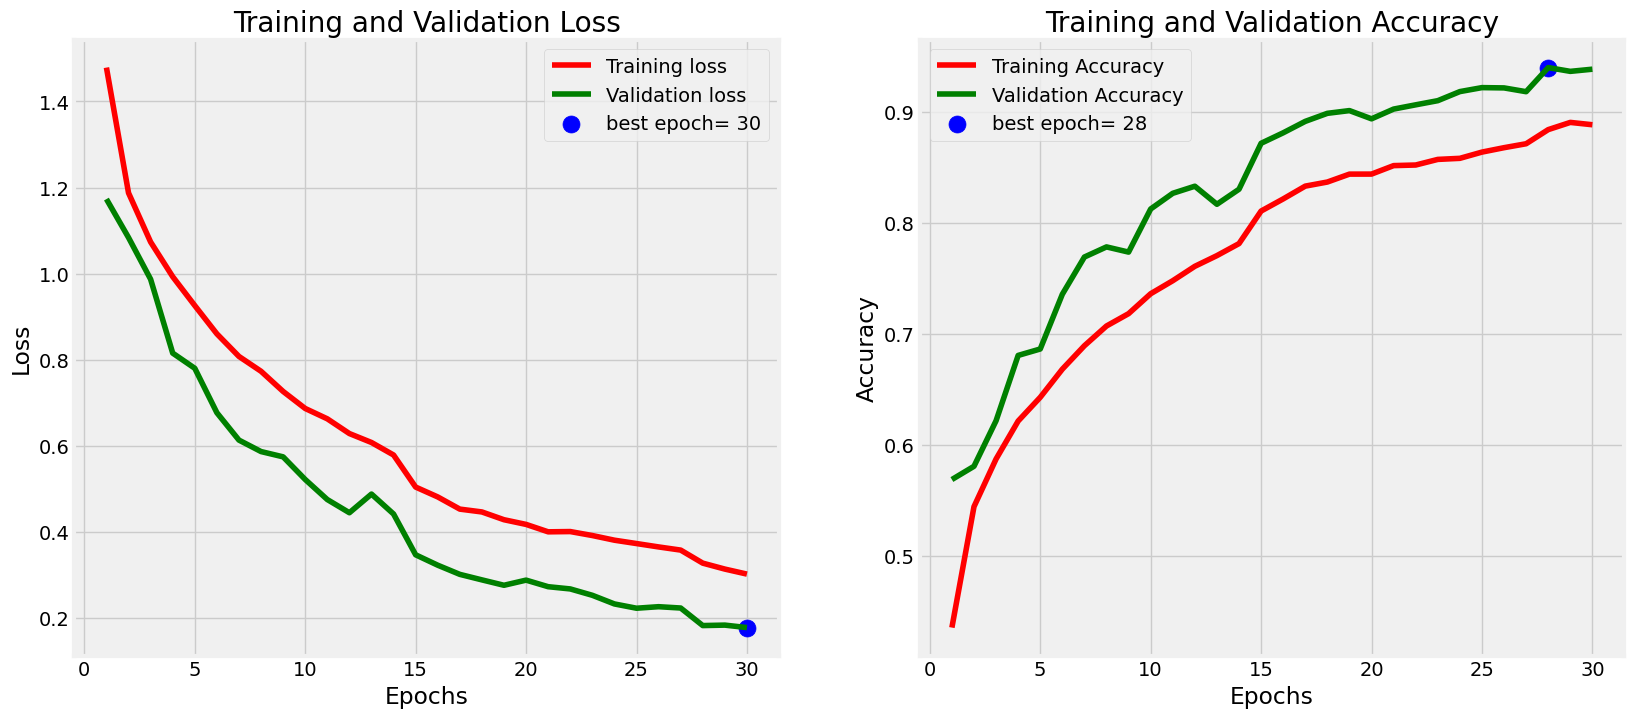

1101/1101 ━━━━━━━━━━━━━━━━━━━━ 23s 17ms/step - accuracy: 0.9555 - loss: 0.1319
367/367 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.9388 - loss: 0.1757


W0000 00:00:1713185105.399341      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Train Loss:  0.12977658212184906
Train Accuracy:  0.9568762183189392
--------------------
Test Loss:  0.177917942404747
Test Accuracy:  0.9386398792266846
367/367 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step


W0000 00:00:1713185114.182276      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


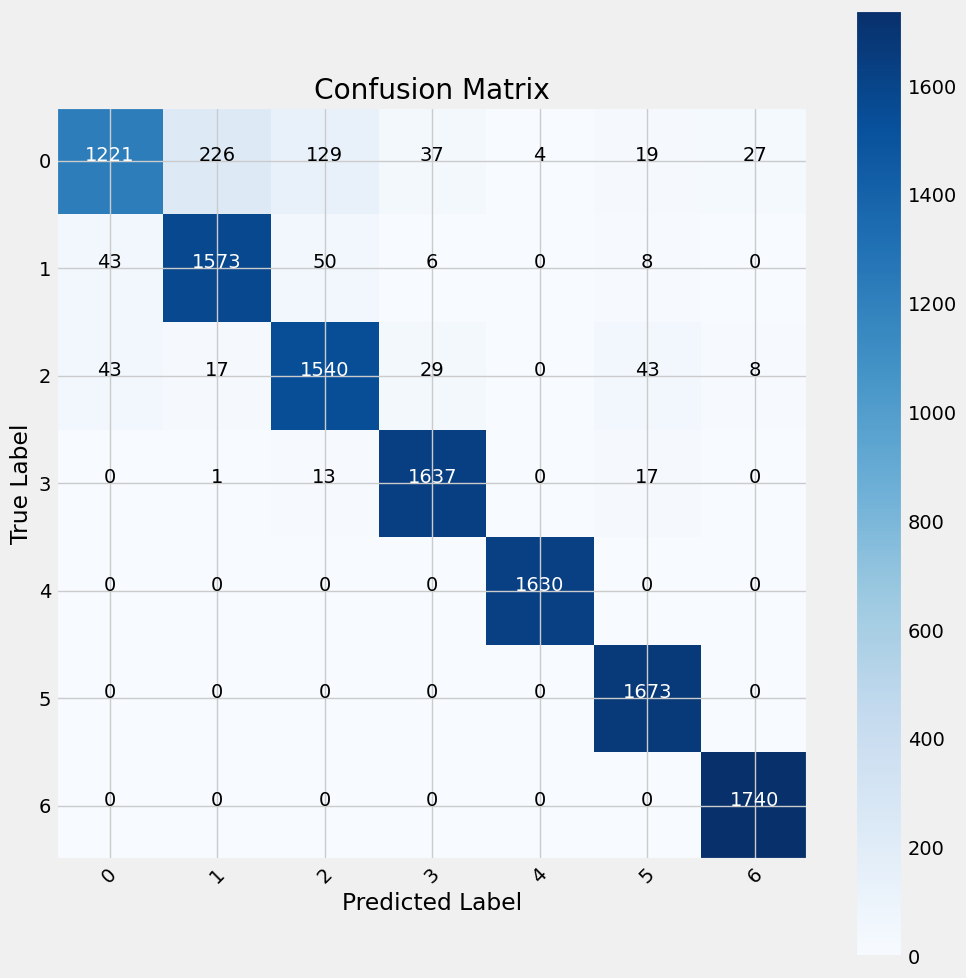

In [12]:
model_56_56_vgg=model_evaluation(model_56_56_vgg,history_56_56_vgg,X_train_56_56,X_test_56_56,y_train_56_56,y_test_56_56)

In [14]:
model_56_56_vgg.save('version_56_56_vgg.h5')

In [15]:
data_dir1='/kaggle/input/pixel-data-32-32/pixel_data_32_32.csv'
size1=[32,32]

In [16]:
X_train_32_32,X_test_32_32,y_train_32_32,y_test_32_32=preprocess(data_dir=data_dir1,size=size1)

Balancing the Data
Shape of Data : (46935, 3072)
Balancing the Data: Complete


In [17]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(size1[0], size1[1], 3))
for layer in base_model.layers:
    layer.trainable = False
model_32_32_vgg,history_32_32_vgg=transfer_learning_model(base_model=base_model,X_train=X_train_32_32,X_test=X_test_32_32,y_train=y_train_32_32,y_test=y_test_32_32,epochs=30)

Epoch 1/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 30s 62ms/step - accuracy: 0.3685 - loss: 1.6712 - val_accuracy: 0.5467 - val_loss: 1.2056 - learning_rate: 0.0010
Epoch 2/30
  7/276 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.5276 - loss: 1.2541

W0000 00:00:1713185219.076714      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


276/276 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.5360 - loss: 1.2202 - val_accuracy: 0.5730 - val_loss: 1.0907 - learning_rate: 0.0010
Epoch 3/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.5764 - loss: 1.1152 - val_accuracy: 0.6462 - val_loss: 0.9296 - learning_rate: 0.0010
Epoch 4/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.6043 - loss: 1.0426 - val_accuracy: 0.6646 - val_loss: 0.8474 - learning_rate: 0.0010
Epoch 5/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.6367 - loss: 0.9582 - val_accuracy: 0.6857 - val_loss: 0.8067 - learning_rate: 0.0010
Epoch 6/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.6640 - loss: 0.8794 - val_accuracy: 0.7171 - val_loss: 0.7237 - learning_rate: 0.0010
Epoch 7/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.6956 - loss: 0.8118 - val_accuracy: 0.7511 - val_loss: 0.6522 - learning_rate: 0.0010
Epoch 8/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.7139 - loss: 0.7546 - val_

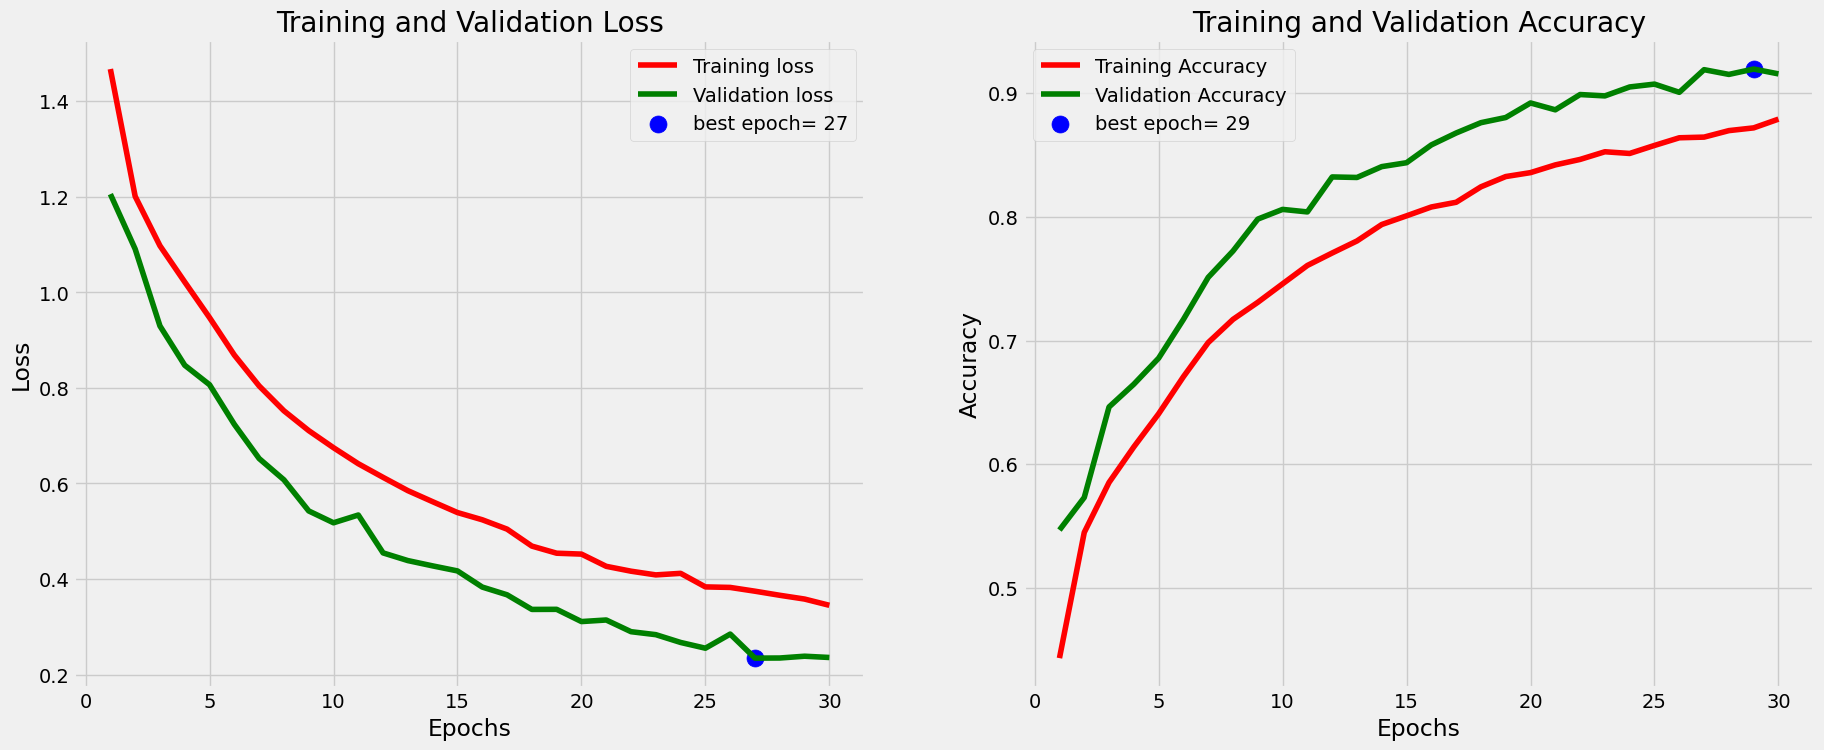

1101/1101 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.9373 - loss: 0.1777
367/367 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9146 - loss: 0.2390
Train Loss:  0.17601199448108673
Train Accuracy:  0.9386380910873413
--------------------
Test Loss:  0.23564009368419647
Test Accuracy:  0.9156298041343689
367/367 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step


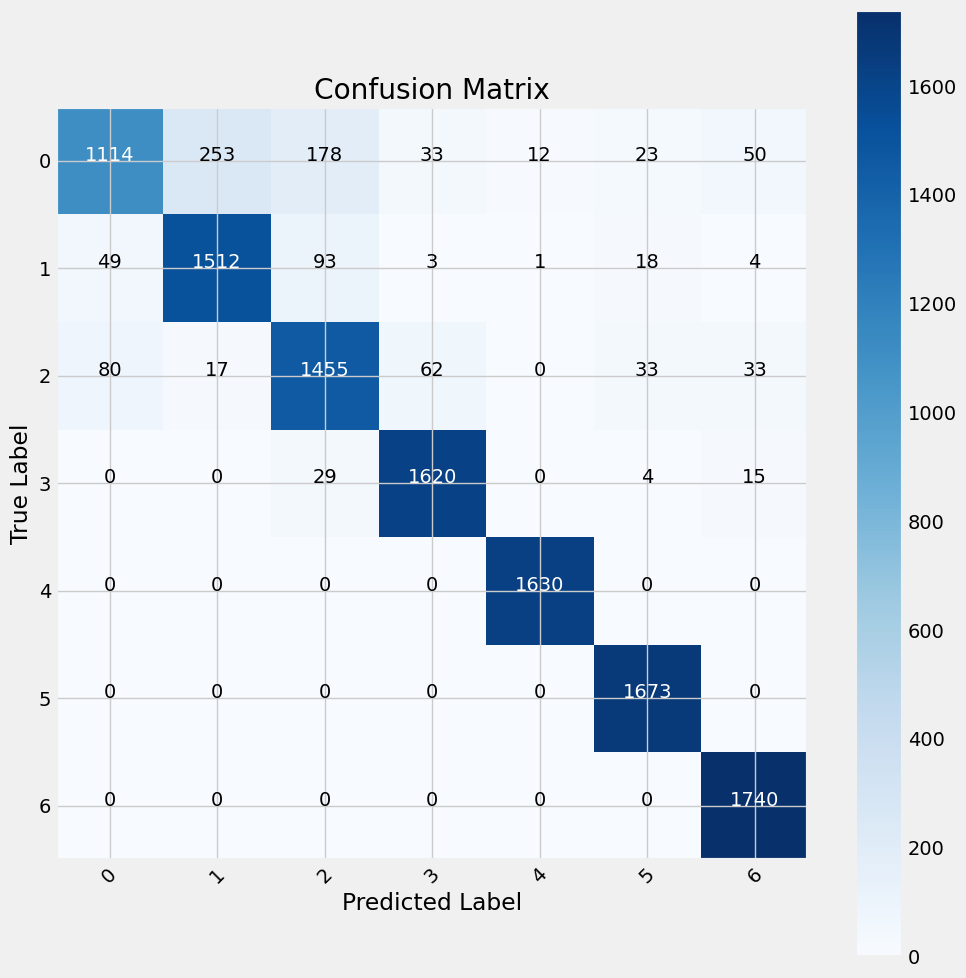

In [18]:
model_32_32_vgg=model_evaluation(model_32_32_vgg,history_32_32_vgg,X_train_32_32,X_test_32_32,y_train_32_32,y_test_32_32)

In [19]:
model_32_32_vgg.save('version_32_32_vgg.h5')

In [21]:
from keras.applications import ResNet50


In [25]:
def transfer_learning_model_resNet(base_model,X_train,X_test,y_train,y_test,
                            optimizer="Adam",loss="categorical_crossentropy",
                            metrics=['accuracy'],epochs=30,batch_size=128):
    
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy'
                                            , patience = 2
                                            , verbose=1
                                            ,factor=0.5
                                            , min_lr=0.00001)

    x = Flatten()(base_model.output)
    x = Dropout(0.2)(x)
    x = Dense(2048, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(32, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(16, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(7, activation='softmax')(x)


    model = Model(inputs=base_model.input, outputs=x)

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
#     model.summary()

    history=model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    callbacks=[learning_rate_reduction]
    )

    return model,history

In [31]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(size1[0], size1[1], 3))
for layer in base_model.layers:
    layer.trainable = False
model_32_32_resNet50,history_32_32_resNet50=transfer_learning_model_resNet(base_model=base_model,X_train=X_train_32_32,X_test=X_test_32_32,y_train=y_train_32_32,y_test=y_test_32_32,epochs=50)

Epoch 1/50
  9/276 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.1419 - loss: 2.3594  

W0000 00:00:1713186273.025054      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.1620 - loss: 2.0682

W0000 00:00:1713186286.902246      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


276/276 ━━━━━━━━━━━━━━━━━━━━ 34s 62ms/step - accuracy: 0.1620 - loss: 2.0678 - val_accuracy: 0.2334 - val_loss: 1.8210 - learning_rate: 0.0010
Epoch 2/50
  7/276 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.2359 - loss: 1.8412

W0000 00:00:1713186289.975049      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


276/276 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.2177 - loss: 1.8480 - val_accuracy: 0.2669 - val_loss: 1.7914 - learning_rate: 0.0010
Epoch 3/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.2367 - loss: 1.8207 - val_accuracy: 0.2363 - val_loss: 1.7939 - learning_rate: 0.0010
Epoch 4/50
273/276 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2508 - loss: 1.7967
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
276/276 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.2509 - loss: 1.7967 - val_accuracy: 0.2393 - val_loss: 1.8241 - learning_rate: 0.0010
Epoch 5/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.2655 - loss: 1.7833 - val_accuracy: 0.2631 - val_loss: 1.7610 - learning_rate: 5.0000e-04
Epoch 6/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.2738 - loss: 1.7644 - val_accuracy: 0.3050 - val_loss: 1.7180 - learning_rate: 5.0000e-04
Epoch 7/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.2785 - loss: 1.7596

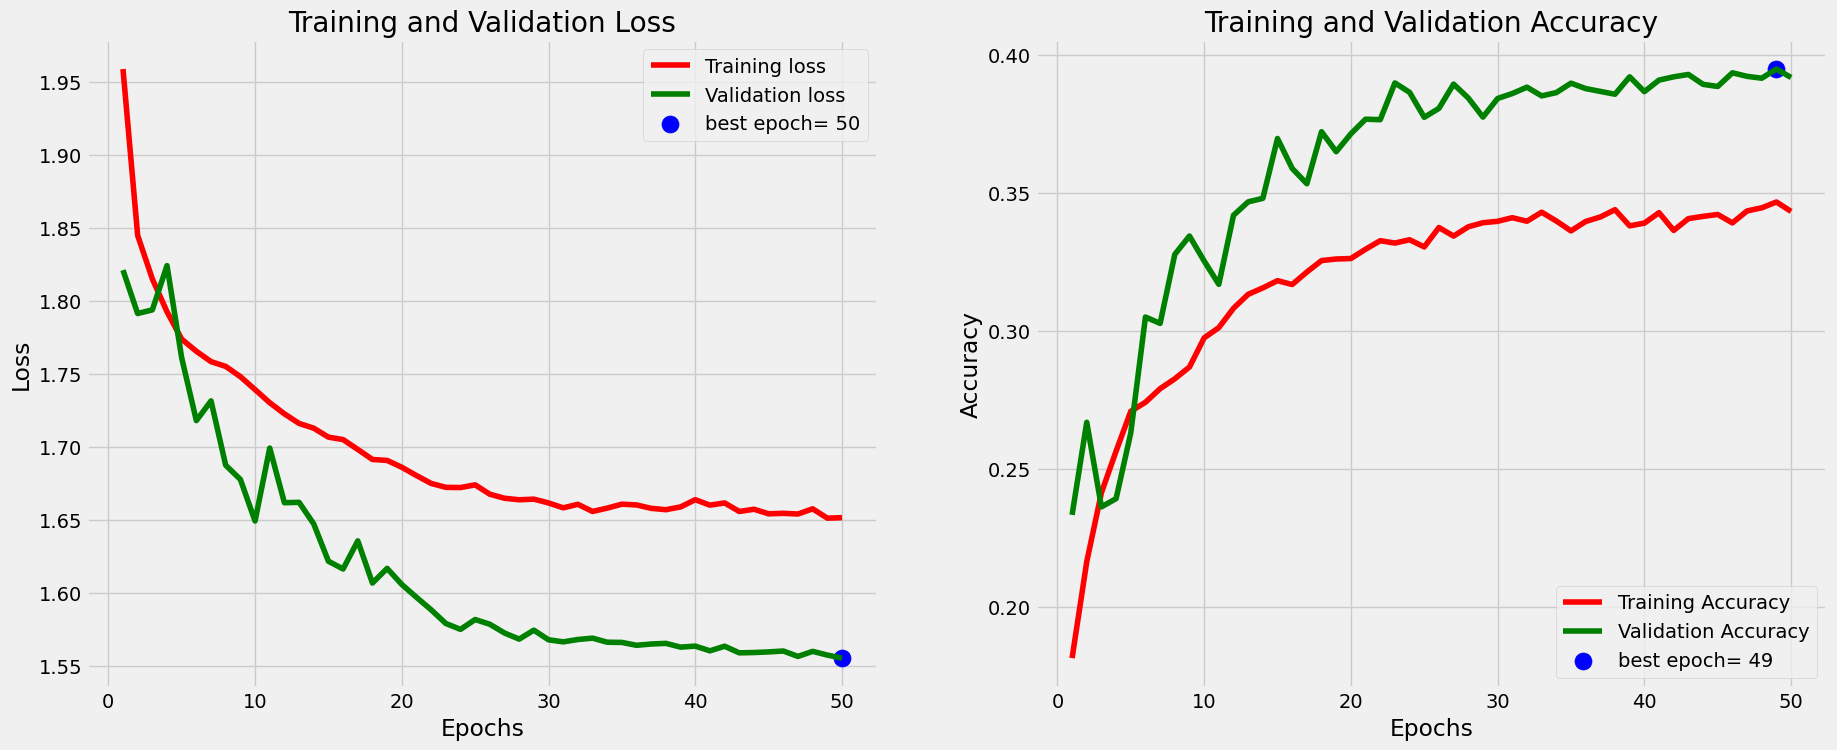

  15/1101 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.3783 - loss: 1.5783

W0000 00:00:1713186545.396183      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1101/1101 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.3975 - loss: 1.5464
367/367 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.3885 - loss: 1.5572


W0000 00:00:1713186560.623305      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Train Loss:  1.550222635269165
Train Accuracy:  0.39481833577156067
--------------------
Test Loss:  1.5548220872879028
Test Accuracy:  0.39168229699134827
 19/367 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step

W0000 00:00:1713186565.155169      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


367/367 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step


W0000 00:00:1713186571.018639      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


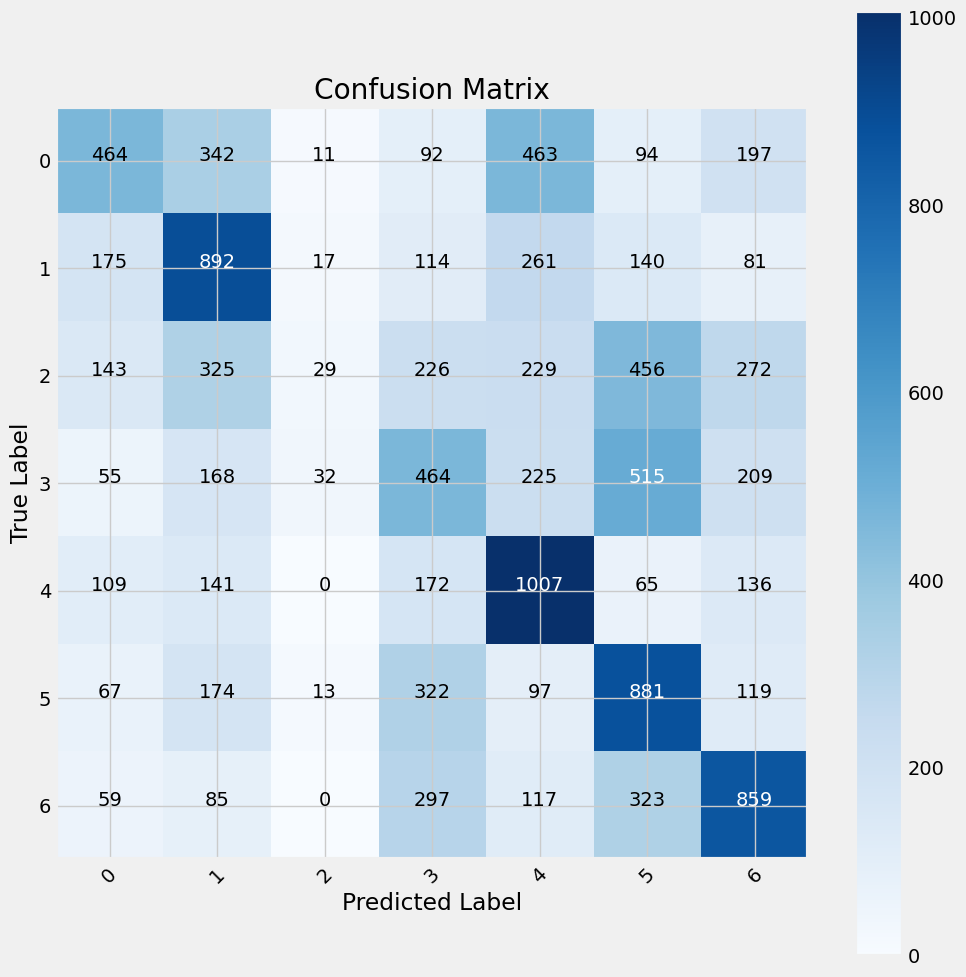

In [32]:
model_32_32_resNet50=model_evaluation(model_32_32_resNet50,history_32_32_resNet50,X_train_32_32,X_test_32_32,y_train_32_32,y_test_32_32)

In [33]:
model_32_32_resNet50.save('version_32_32_resNet50.h5')

In [34]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(size[0], size[1], 3))
for layer in base_model.layers:
    layer.trainable = False
model_56_56_resNet50,history_56_56_resNet50=transfer_learning_model_resNet(base_model=base_model,X_train=X_train_56_56,X_test=X_test_56_56,y_train=y_train_56_56,y_test=y_test_56_56,epochs=50)

Epoch 1/50
  4/276 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step - accuracy: 0.1455 - loss: 2.3611

W0000 00:00:1713186599.871256      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.1523 - loss: 2.0695

W0000 00:00:1713186622.674765      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


276/276 ━━━━━━━━━━━━━━━━━━━━ 52s 110ms/step - accuracy: 0.1523 - loss: 2.0692 - val_accuracy: 0.1642 - val_loss: 1.9989 - learning_rate: 0.0010
Epoch 2/50
  3/276 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.1832 - loss: 1.9271

W0000 00:00:1713186630.068829      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


276/276 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.1971 - loss: 1.8873 - val_accuracy: 0.2064 - val_loss: 1.8790 - learning_rate: 0.0010
Epoch 3/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.2174 - loss: 1.8550 - val_accuracy: 0.1639 - val_loss: 2.0416 - learning_rate: 0.0010
Epoch 4/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.2210 - loss: 1.8407 - val_accuracy: 0.2187 - val_loss: 1.8560 - learning_rate: 0.0010
Epoch 5/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.2273 - loss: 1.8266 - val_accuracy: 0.2771 - val_loss: 1.7650 - learning_rate: 0.0010
Epoch 6/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.2517 - loss: 1.8060 - val_accuracy: 0.3143 - val_loss: 1.7161 - learning_rate: 0.0010
Epoch 7/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.2670 - loss: 1.7833 - val_accuracy: 0.2801 - val_loss: 1.7386 - learning_rate: 0.0010
Epoch 8/50
275/276 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2735 - loss: 1.7698


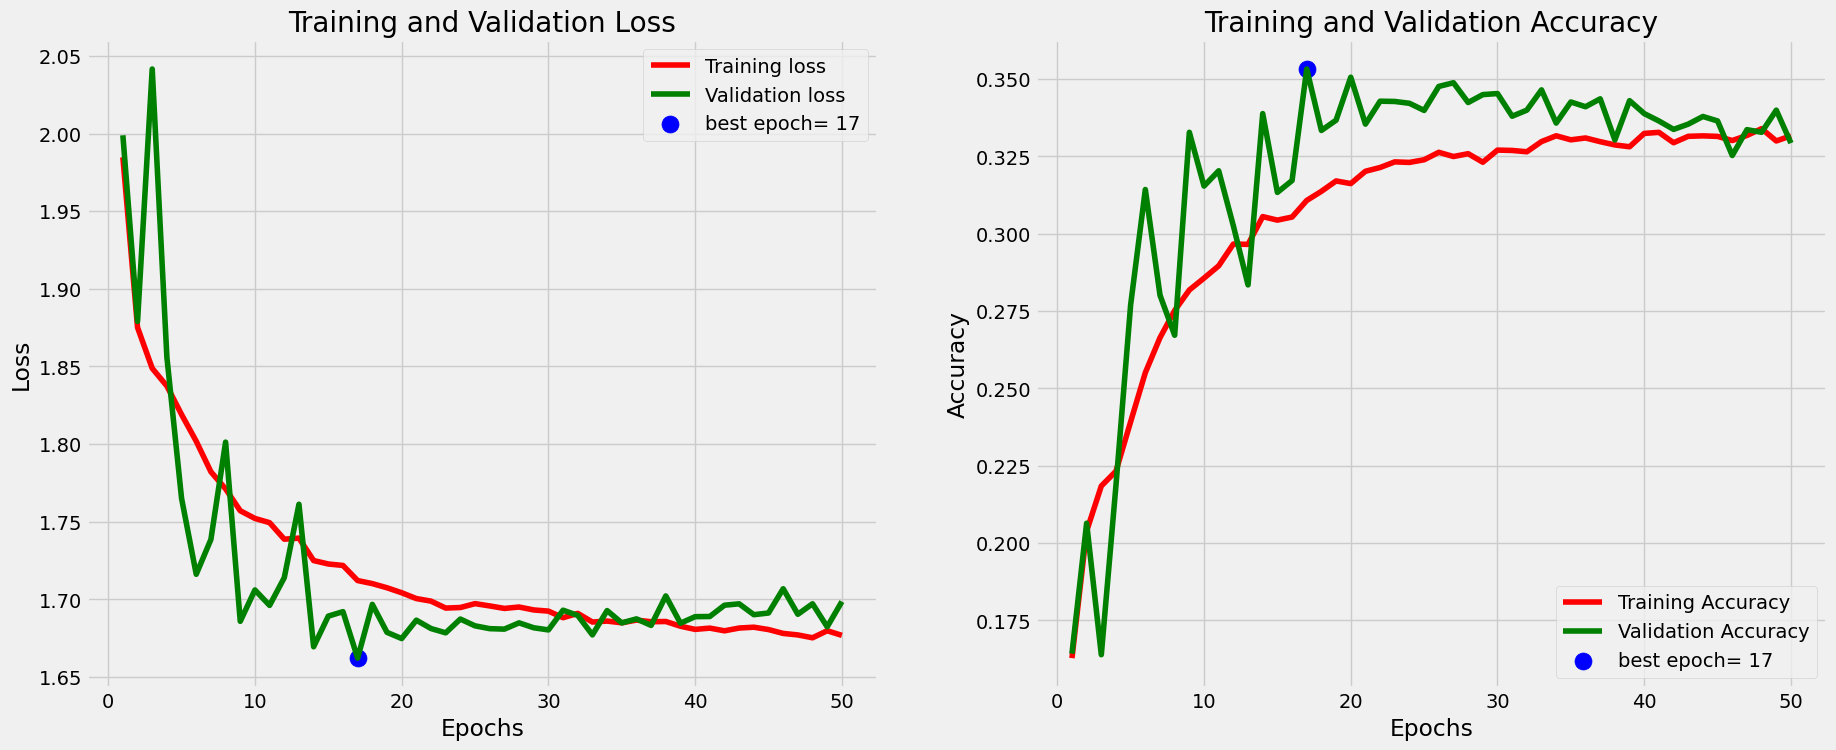

  15/1101 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.3080 - loss: 1.7283

W0000 00:00:1713187262.269244      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1101/1101 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.3369 - loss: 1.6896
367/367 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.3298 - loss: 1.6888


W0000 00:00:1713187288.254405      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Train Loss:  1.6919901371002197
Train Accuracy:  0.3360700011253357
--------------------
Test Loss:  1.6982395648956299
Test Accuracy:  0.3292994797229767
 13/367 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step

W0000 00:00:1713187293.491745      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


367/367 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step


W0000 00:00:1713187301.727621      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


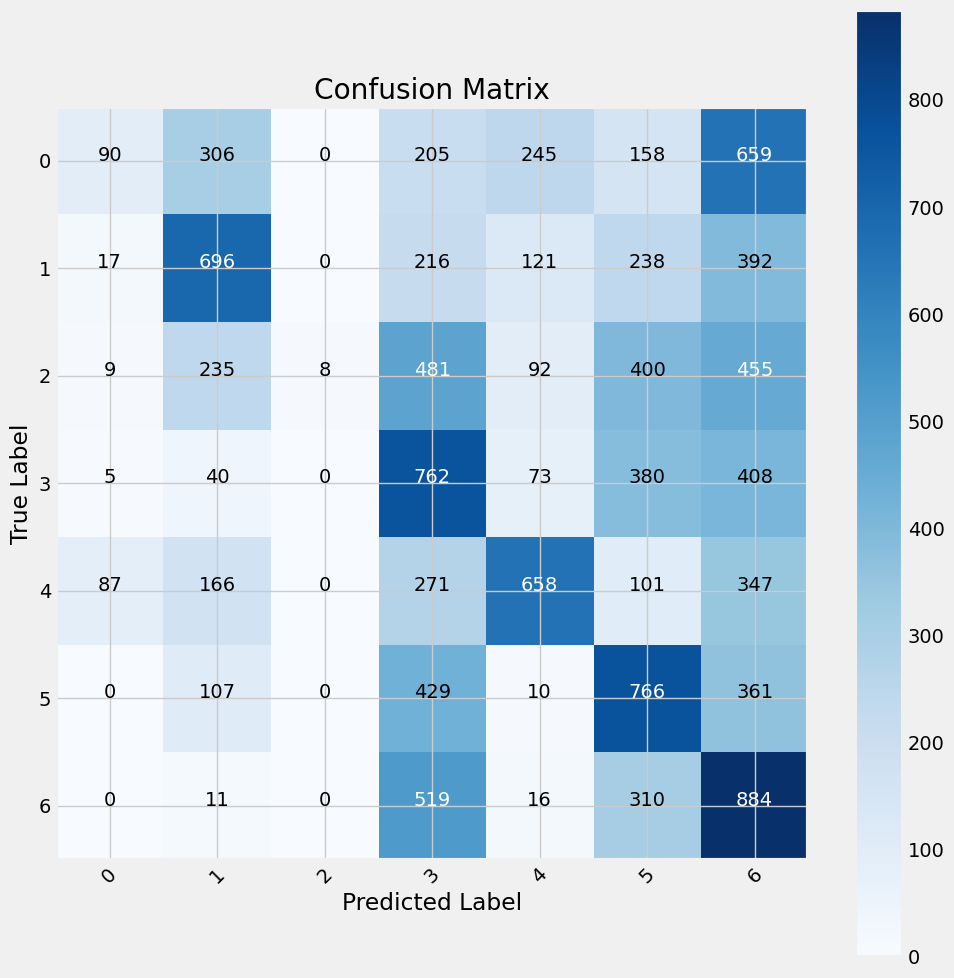

In [35]:
model_56_56_resNet50=model_evaluation(model_56_56_resNet50,history_56_56_resNet50,X_train_56_56,X_test_56_56,y_train_56_56,y_test_56_56)

In [36]:
model_56_56_resNet50.save('version_56_56_resNet50.h5')